# LAB 3
# Learn the basics of Apache Spark in Watson Studio Notebooks

This notebook introduces you to the basics of analytics notebooks and explains what Apache Spark is and how to use Spark in notebooks.   
The notebook shows you how to load data into the notebook, parse and explore the data, run queries on the data to extract information, plot your analysis results, and save your result in Object Storage.

This notebooks runs on Python 3.5 with Spark 2.1, and Cloud Object Storage

## Table of contents
- [What is Apache Spark](#apache_spark)
- [Get data over FTP](#data_set)
- [Load data](#load_data)
- [Access data](#access_data)
- [Add header](#add_header)
- [Parse data](#parse_data)
- [Explore data](#explore_data)
- [Use Spark SQL](#use_spark_sql)
- [Save results in Object Storage](#save)
- [Summary](#summary)

In [1]:
# Timing function
from datetime import datetime
Timings={}
def timing(tag,fromTag=None):
    Timings[tag]=datetime.now()
    if fromTag:
        print("`{0}` at {1}, elapsed since {2}: {3}".format(tag,Timings[tag],fromTag,Timings[tag]-Timings[fromTag]))
    else:
        print("`{0}` at {1}".format(tag,Timings[tag]))
timing("A_Start")

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20180925124919-0000
`A_Start` at 2018-09-25 12:49:21.220543


<a id="apache_spark"></a>
## What is Apache Spark

[Spark](http://spark.apache.org/) is a fast open-source engine for large-scale data processing. It is built for speed and ease of use. Through the advanced DAG execution engine that supports cyclic data flow and in-memory computing, programs can run up to 100 times faster than Hadoop MapReduce in memory, or 10 times faster on disk.

Spark consists of multiple components:

* __Spark Core__ is the underlying computation engine with the fundamental programming abstraction called __R__ esilient __D__ istributed __D__ atasets (__RDD__ s)
* __Spark SQL__ provides a new data abstraction called DataFrames for structured data processing with SQL and domain-specific language
* __MLlib__ is a scalable machine learning framework for delivering fast distributed algorithms for mining big data
* __Streaming__ leverages Spark's fast scheduling capability to perform real-time analysis on streams of new data
* __GraphX__ is the graph processing framework for the analysis of graph structured data

In this introductory tutorial example, you will focus on `Spark Core` and `Spark SQL` by using the Python API.

### Setting up access to COS

In order to get credentials to write to COS, we will use those of an existing file.   

Select any file from the files list on the right-side files panel, and use `insert to code`/`Insert Credentials` in the cell below.   

>The credentials object that is created for you is given a generic name, such as *credentials_1*. Rename it to `YourCredentials` before you run the cell (i.e. replace `credentials_1 =` with `YourCredentials =`.

In [2]:
#
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
YourCredentials = {
    'IBM_API_KEY_ID': 'ZATI1oq_TlsWqN-oEz3Wo1IPXWwOkCx0PXV3gj0d5eui',
    'IAM_SERVICE_ID': 'iam-ServiceId-521e4bd0-5161-49f0-9e11-474c674a5fe7',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
    'BUCKET': 'watstudworkshop-donotdelete-pr-basx79wonvxlys',
    'FILE': '201701-citibike-tripdata.csv'
    #,'NOTTHISONE': "Insert YOUR OWN Credentials as `YourCredentials` in the cell above!!!"
}


In [3]:
# Setup access to COS
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
def __iter__(self): return 0

try:
    raise Exception(YourCredentials['NOTTHISONE'])
except KeyError: pass

bucket_name = YourCredentials['BUCKET']
object_name = '2017.csv'

cos = ibm_boto3.client('s3',
    ibm_api_key_id=YourCredentials['IBM_API_KEY_ID'],
    ibm_auth_endpoint=YourCredentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=YourCredentials['ENDPOINT'])

<a id="data_set"></a>
## Getting data

In this example, you will use Apache Spark to analyze weather data collected from weather stations in 2017. This data is provided by the NOAA National Climatic Data Center (NCDC).

We will get the `2017.csv.gz` file, which is quite large after unpacking, directly from its source over FTP download.

If you were to manually get at the raw data from the NOAA National Climatic Data Center (NCDC), you would:
1. Visit the NCDC site at http://www.ncdc.noaa.gov/data-access/quick-links.
2. Click **Global Historical Climatology Network-Daily (GHCN-D)**.
3. Click **GHCN-Daily FTP Access**.
4. Click the `by_year` folder.
5. Scroll to the bottom and click **2017.csv.gz** to download the data set [2017.csv.gz](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2017.csv.gz)
6. After the file was downloaded, extract it.
7. Click **ghcn-daily-by_year-format.rtf** to download additional infromation, e.g. header, for the data set. (ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/ghcn-daily-by_year-format.rtf)

### Fetching the data file over FTP
If the file is not found in COS storage, we will first get it directly from its original FTP source, by escaping to the underlying linux virtual machine.   
Linux commands can be issued using the `!` prefix.

We use `wget` and `gunzip` commands.

> NOTE: This set of cells needs to be executed only once. After the file is stored into COS, it will be fetched from there directly by Spark.

In [4]:
timing("B_BeforeFTPAndCOS")

`B_BeforeFTPAndCOS` at 2018-09-25 12:49:21.777953


In [5]:
# Get the file via FTP download
!rm 2017.csv*
!wget ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2017.csv.gz
!ls -l 2017*
# Unzip the file
!gunzip -f 2017.csv.gz
!ls -l 2017*

rm: cannot remove '2017.csv*': No such file or directory
--2018-09-25 12:49:22--  ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2017.csv.gz
           => '2017.csv.gz'
Resolving ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)... 205.167.25.101, 2610:20:8040:2::101
Connecting to ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)|205.167.25.101|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/data/ghcn/daily/by_year ... done.
==> SIZE 2017.csv.gz ... 198438583
==> PASV ... done.    ==> RETR 2017.csv.gz ... done.
Length: 198438583 (189M) (unauthoritative)

2017.csv.gz         100%[===================>] 189.25M  23.1MB/s    in 10s     

2018-09-25 12:49:34 (18.5 MB/s) - '2017.csv.gz' saved [198438583]

-rw-r--r-- 1 spark spark 198438583 Sep 25 12:49 2017.csv.gz
-rw-r--r-- 1 spark spark 1216642959 Sep 25 12:49 2017.csv


### Store the downloaded and unzipped file to COS

In [6]:
# Send the file to COS from file system
with open(object_name, "rb") as f:
    cos.upload_fileobj(f,bucket_name,object_name)

print("Done, file {0} uploaded to COS bucket {1}".format(object_name,bucket_name))
timing("B_AfterFTPAndCOS","B_BeforeFTPAndCOS")

Done, file 2017.csv uploaded to COS bucket watstudworkshop-donotdelete-pr-basx79wonvxlys
`B_AfterFTPAndCOS` at 2018-09-25 12:50:02.452875, elapsed since B_BeforeFTPAndCOS: 0:00:40.674922


Note that you could at this stage go back to the project's Data Assets section and add the file from COS as a Data Asset

<a id="load_data"></a>
## Load data into Spark from COS
We will now load the CSV file from COS storage into the notebook's Spark environment
<a id="access_data"></a>
## Access data
Before you can access data in the data file in the Object Storage, you must setup the Spark configuration with your Object Storage credentials. 

Note that the COS credentials have already been added above. The cell below just copies them to a data structure appropriate for Spark.

In [7]:
import ibmos2spark

timing("C_BeforeDownloadingFromCOS")

# Create credentials in the format required by CloudObjectStorage
credentials = {
    'endpoint': YourCredentials['ENDPOINT'],
    'api_key': YourCredentials['IBM_API_KEY_ID'],
    'service_id': YourCredentials['IAM_SERVICE_ID']
}

configuration_name = 'wheather_data_2017_config_os'
# See https://github.com/ibm-watson-data-lab/ibmos2spark/tree/master/python
cos = ibmos2spark.CloudObjectStorage(sc, credentials,
                                    configuration_name=configuration_name,
                                    cos_type='bluemix_cos')

# The `sc` object is your SparkContext object
# The `cos` object will provide the URL for SparkContext to retrieve your data

# Get the URL
data_url = cos.url(object_name, bucket_name)
timing("C_AfterDownloadingFromCOS","C_BeforeDownloadingFromCOS")

print("COS URL for the data asset: {0}".format(data_url))

`C_BeforeDownloadingFromCOS` at 2018-09-25 12:50:02.474711
`C_AfterDownloadingFromCOS` at 2018-09-25 12:50:02.480530, elapsed since C_BeforeDownloadingFromCOS: 0:00:00.005819
COS URL for the data asset: cos://watstudworkshop-donotdelete-pr-basx79wonvxlys.wheather_data_2017_config_os/2017.csv


The data in the base file has the following format:

<table border="1" style="width:90%">
  <tr>
    <th>STATION</th><th>DATE</th><th>METRIC</th><th>VALUE</th><th>C5</th><th>C6</th><th>C7</th><th>C8</th>
  </tr>
  <tr>
    <td>US1NCBC0113</td><td>20170101</td><td>PRCP</td><td>5</td><td></td><td></td><td>N</td><td></td>
  </tr>
  <tr>
    <td>CA1MB000296</td><td>20170101</td><td>PRCP</td><td>0</td><td></td><td></td><td>N</td><td></td>
  </tr>
  <tr>
    <td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td></td>
  </tr>
  <tr>
    <td>US1MTMH0019</td><td>20170101</td><td>SNOW</td><td>28</td><td></td><td></td><td>N</td><td></td>
  </tr>
  <tr>
    <td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td>...</td><td></td>
  </tr>
  <tr>
    <td>USW00024229</td><td>20170101</td><td>TMAX</td><td>44</td><td></td><td></td><td>W</td><td>2400</td>
  </tr>
</table>
<p>

Each row contains a weather station identifier, a date, a metric which is collected (like precipitation, daily maximum and minimum temperatures, temperature at the time of observation, snowfall, snow depth, and so on) and some additional values.

**Note**: The header is not included in the CSV file and is documented in **ghcn-daily-by_year-format.rtf**. It was added to the table above to provide clarity on what information each column contains.

Now let's load the data into a `Spark RDD` we will call `weather` by using the `SparkContext`.

In [8]:
timing("D_BeforeLoadingData")
# Now we load the data. Note that Spark uses lazy evaluation, so the lengthy operation will be take()
weather = sc.textFile(data_url)
# take() triggers the Spark job that loads the data, See the Spark Job Progress gauge
weather.take(5)
timing("D_AfterLoadingData","D_BeforeLoadingData")

`D_BeforeLoadingData` at 2018-09-25 12:50:02.493291
`D_AfterLoadingData` at 2018-09-25 12:50:09.934441, elapsed since D_BeforeLoadingData: 0:00:07.441150


You can now access the data by using the preconfigured `SparkContext` function in your notebook.

The RDD you created is a collection of strings corresponding to the individual lines in the raw data file. It is also important to remember that the RDD is defined but not instantiated. By applying an action like `count` to the RDD, you effectively instantiate the RDD.

In [9]:
print("Total records in the data set: {0}".format(weather.count()))

Total records in the data set: 34753239


Apply another action to the same RDD that reads the first row of the data.

In [10]:
print("The first row in the data set: {0}".format(weather.first()))

The first row in the data set: US1MISW0005,20170101,PRCP,0,,,N,


<a id="add_header"></a>
## Add header

Since the header is not included in the CSV file, it has to be added programmatically.  

In [11]:
# Create a RDD from Python array to represent Header (see https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.parallelize)
header = sc.parallelize(['STATION,DATE,METRIC,VALUE,C5,C6,C7,C8'])
# Append the header and data into a single RDD
weather = header.union(weather)
weather.take(2)

['STATION,DATE,METRIC,VALUE,C5,C6,C7,C8', 'US1MISW0005,20170101,PRCP,0,,,N,']

<a id="parse_data"></a>
## Parse data

To really begin working with the data, you need to parse it into columns. You can do this by mapping each line in the RDD to a function that splits the line by commas.

The lambda notation in Python is used to create anonymous functions, in other words, functions which are not bound to a name. This concept is used in the previous code cell to pass a function as a parameter to the `map` function. The anonymous function receives each line from the `weather` RDD  and splits it at comma boundaries. As a result, the new `weatherParse` RDD is defined as a list of lists. Each list in `weatherParse` corresponds to a line in `weather`, and the strings in each list are the individual elements of the row.

In [12]:
timing("E_BeforeParsing")
weatherParse = weather.map(lambda line : line.split(","))

`E_BeforeParsing` at 2018-09-25 12:50:36.762551


Run the next cell for a quick look at the first list:

In [13]:
weatherParse.first()

['STATION', 'DATE', 'METRIC', 'VALUE', 'C5', 'C6', 'C7', 'C8']

Now take a look at the individual elements of this first list where the first entry starts at offset zero.

In [14]:
weatherParse.first()[0]

'STATION'

You can also pull elements by index.

In [15]:
weatherParse.first()[2]

'METRIC'

In [16]:
timing("E_AfterParsing","E_BeforeParsing")

`E_AfterParsing` at 2018-09-25 12:50:39.762583, elapsed since E_BeforeParsing: 0:00:03.000032


<a id="explore_data"></a>
## Explore data
To better consume the precipitation data, it has to be converted or mapped from one raw form into another format.


### Calculate the average precipitation by weather station
To calculate the average precipitation that was recorded at each weather station in the data set, reduce the data set by selecting only those rows with precipitation data values, in other words, those rows where the `METRIC` column at index 2 holds the `PRCP` value.   
See https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.filter for information on the `filter()` RDD function

In [17]:
# Create a new RDD which holds only rows which represent precipitation events
weatherPrecp = weatherParse.filter(lambda x: x[2] == "PRCP")
# Display first 3 lines
weatherPrecp.take(3)

[['US1MISW0005', '20170101', 'PRCP', '0', '', '', 'N', ''],
 ['US1MNCV0008', '20170101', 'PRCP', '0', '', '', 'N', ''],
 ['CA1MB000296', '20170101', 'PRCP', '0', '', '', 'N', '']]

As shown above, the `weatherPrecp` RDD that you created contains the subset of weather observations that are precipitation values.   The first column at index 0 is the `Station identifier`, index [1] is the observation date, and index[3] is the value.

Next, we will transform `map` this data set into a new one with a new structure, where each row will retain only the station ID, associated with a pair made of the precipitation value augmented by a new column with the value `1`:

In [18]:
# Map to tuples with station ID as first element, then a tuple made of the precipitation measure and a constant 1
# x[0] is the station, x[3] is the precipitation value
weatherPrecpCountByKey = weatherPrecp.map(lambda x : (x[0], (int(x[3]), 1)))
weatherPrecpCountByKey.take(3)

[('US1MISW0005', (0, 1)), ('US1MNCV0008', (0, 1)), ('CA1MB000296', (0, 1))]

As shown above, this results in a RDD with a structure as shown in Table 2:
#### Table 2.

<table border="1" style="width:80%" align="left">
  <tr>
    <th>Key</th><th>Value</th>
  </tr>
  <tr>
    <td>Station 1</td><td>(Value 1,1)</td>
  </tr>
  <tr>
    <td>Station 2</td><td>(Value 2,1)</td>
  </tr>
    <tr>
    <td>Station 1</td><td>(Value 3,1)</td>
  </tr>
    <tr>
    <td>Station 2</td><td>(Value 4,1)</td>
  </tr>
    <tr>
    <td>Station 3</td><td>(Value 5,1)</td>
  </tr>
  <tr>
    <td>...</td><td>...</td>
  </tr>
</table>
<p>

Now, using this table, you can compute the average precipitation for each station by dividing the summation of the values by the corresponding count, so as to reduce the table into the form represented by Table 3:
#### Table 3.

<table border="1" style="width:80%" align="left">
  <tr>
    <th>Key</th><th>Value</th>
  </tr>
  <tr>
    <td>Station 1</td><td>(Value 1 + Value 3,2)</td>
  </tr>
  <tr>
    <td>Station 2</td><td>(Value 2 + Value 4,2)</td>
  </tr>
    <tr>
    <td>Station 3</td><td>(Value 5,1)</td>
  </tr>
  <tr>
    <td>...</td><td>...</td>
  </tr>
</table>
<p>

In [19]:
timing("F_AfterFiltering","E_AfterParsing")

`F_AfterFiltering` at 2018-09-25 12:50:41.419398, elapsed since E_AfterParsing: 0:00:01.656815


### Calculate the total precipitation by weather station

To calculate the total precipitation by weather station, sum (reduce) the precipitation amounts and total readings for every station. We use the `reduceByKey` function for this purpose (see https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey)   
`reduceByKey` will call the `lambda` function for each pair of rows to coallesce, passing the Value column of the rows in v1 and v2.   
We will create a result set RDD format which adds the precipitation values (index[0] of the pair) and count of observations (per station) at index[1]:

In [20]:
weatherPrecpAddByKey = weatherPrecpCountByKey.reduceByKey(lambda v1,v2 : (v1[0]+v2[0], v1[1]+v2[1]))

Using the `first` function, you can inspect the precipitation values and read the totals for the first station ID. Note that this operation might take some time to complete as the whole chain of RDDs that you created are reinstantiated.

In [21]:
weatherPrecpAddByKey.first()

('ASN00040980', (11080, 365))

### Compute the average values per station

Now that you have transformed the data into the format you need it in, you can finally compute the average precipitation values per weather station. You create the `weatherAverages` RDD by mapping the `weatherPrecpAddByKey` RDD through a function that divides the precipitation total by the total number of readings.   
Here, `k` defined as the lambda parameter is a pair, its first value (at index[0] is the Station ID, its second one (at index[1]) is another pair holding the precipitation value and the number of observations.

In [22]:
weatherAverages = weatherPrecpAddByKey.map(lambda k: (k[0], k[1][0] / float(k[1][1] ) ) )

In [23]:
weatherAverages.first()

('ASN00040980', 30.356164383561644)

Now print the first ten stations and their average precipitation values. The station ID is the sort order in the `top` function (See https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.top) because it appears first in the tuple (station ID, average precipitation) in the RDD.

In [24]:
for pair in weatherAverages.top(10):
    print("Station {0} had average precipitations of {1: >8.2f}".format(pair[0],pair[1]))

Station ZI000067983 had average precipitations of    82.49
Station ZI000067975 had average precipitations of    49.17
Station ZI000067775 had average precipitations of    67.14
Station ZA000067743 had average precipitations of   255.43
Station ZA000067475 had average precipitations of   119.00
Station WZ004455110 had average precipitations of    55.61
Station WQW00041606 had average precipitations of    61.22
Station WIM00060096 had average precipitations of    10.56
Station WFM00091754 had average precipitations of   108.04
Station WF000917530 had average precipitations of   100.65


If you want to output the ten weather stations with the highest average precipitation, you need to reverse the order of the tuple to (average precipitation, station ID). You can do this with a `map` function that switches the pair order.

In [25]:
precTop10=[]
stationsTop10=[]
for pair in weatherAverages.map(lambda p : (p[1],p[0])).top(10):
    precTop10.append(pair[0])
    stationsTop10.append(pair[1])
    print("Station {0} had average precipitations of {1: >8.2f}".format(pair[1],pair[0]))

Station US1TXMNG018 had average precipitations of  2809.00
Station US1TXFB0025 had average precipitations of  2161.50
Station US1MOCY0024 had average precipitations of  2009.00
Station US1ILDP0091 had average precipitations of  1918.00
Station US1ILDP0144 had average precipitations of  1808.00
Station US1MOJH0005 had average precipitations of  1803.50
Station US1TXJJ0003 had average precipitations of  1489.75
Station US1NCCL0021 had average precipitations of  1448.00
Station US1TNMT0049 had average precipitations of  1361.00
Station US1TXWK0011 had average precipitations of  1346.20


Now, we will plot the results using matplotlib

In [26]:
timing("G_AfterAverages","F_AfterFiltering")

`G_AfterAverages` at 2018-09-25 12:51:15.947447, elapsed since F_AfterFiltering: 0:00:34.528049


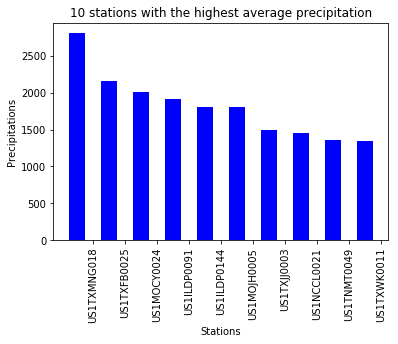

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

N = 10
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, precTop10, bar_width,color='b')
plt.xlabel('Stations')
plt.ylabel('Precipitations')
plt.title('10 stations with the highest average precipitation')
plt.xticks(index + bar_width, stationsTop10, rotation=90)
plt.show()

<a id="use_spark_sql"></a>
## Use Spark SQL

`Spark SQL` lets you query structured data, for example, data in a relational table and can be a very powerful tool for performing complex aggregations.

To create a relational table that you can query using `Spark SQL` and fill it with snowfall data, you'll use the `Row` class from the `pyspark.sql` package. You will use every line in the `weatherSnow` RDD to create a row object. Each of the row's attributes will be used to access the value of each column.

In [28]:
timing("H_BeginSparkSQL")

`H_BeginSparkSQL` at 2018-09-25 12:51:16.780584


To filter the weather data to show only those weather stations that contain the keyword `SNOW`, you need to reduce the data set to lines with `SNOW` in the third (index 2) column.

In [29]:
# Filter where type is snow
weatherSnow = weatherParse.filter(lambda x: x[2]=="SNOW")
print("There are {0} SNOW events".format(weatherSnow.count()))

There are 4357199 SNOW events


The next commands convert each line of the `weatherSnow` RDD into a SparkSQL `Row` object.  
Each row is parsed from the original RDD columns and converted to a tuple with identified types and names.   
This allows to infer and apply a schema for the Spark DataFrame built from the collection of Rows   
Finally register with the table name `snow2017`, this will allow to run SQL queries on the SparkSQL DataFrame

In [30]:
timing("I_BeginBuildSparkSQLDataFrame")
from datetime import datetime
from pyspark.sql import Row
spark = SparkSession.builder.getOrCreate()

# Convert each line of snowWeather RDD into a Row object
snowRows= weatherSnow.map(lambda p: Row(station=p[0], month=datetime.strptime(p[1], '%Y%m%d').month, date=datetime.strptime(p[1], '%Y%m%d').day,metric=p[2], value=int(p[3])))

# Apply Row schema to create a Spark DataFrame
snowSchema = spark.createDataFrame(snowRows)

# Register 'snow2017' table with 5 columns: station, month, date, metric, and value
snowSchema.registerTempTable("snow2017")
timing("I_EndBuildSparkSQLDataFrame","I_BeginBuildSparkSQLDataFrame")

`I_BeginBuildSparkSQLDataFrame` at 2018-09-25 12:51:43.317393
`I_EndBuildSparkSQLDataFrame` at 2018-09-25 12:51:55.201483, elapsed since I_BeginBuildSparkSQLDataFrame: 0:00:11.884090


We now have a Spark DataFrame on which it will be easier to run SQL queries

### Compare the number of snow days between two stations

In this section, you'll calculate the number of snow days for each month of the year at the `US10chey021` 
and `USW00094985` weather stations. With that information, you'll plot a bar chart to compare the number of snow days for each month at the two stations.

First, find out on how many days of every month it snowed at the `US10chey021` weather station, using a Spark-SQL query, and display the result

In [31]:
timing("J_BeginCountSnowDays")
snow_US10chey021 = spark.sql("SELECT month, COUNT(*) AS snowdays FROM snow2017 WHERE station='US10chey021' GROUP BY month ORDER BY month").collect()
timing("J_EndCountSnowDays","J_BeginCountSnowDays")
snow_US10chey021

`J_BeginCountSnowDays` at 2018-09-25 12:51:55.210348
`J_EndCountSnowDays` at 2018-09-25 12:52:46.665356, elapsed since J_BeginCountSnowDays: 0:00:51.455008


[Row(month=1, snowdays=28),
 Row(month=2, snowdays=27),
 Row(month=3, snowdays=21),
 Row(month=4, snowdays=19),
 Row(month=5, snowdays=10),
 Row(month=10, snowdays=2),
 Row(month=11, snowdays=1),
 Row(month=12, snowdays=1)]

Note that we now have a list of Rows with the aggregation of snowdays for each month when there has been snow:

In [32]:
# Convert to a python array of 12 elements initialized to 0
US10chey021_snowdays_y=[0] * 12
# fill-in array with snow days per month (notice the 0-indexed array versus 1-indexed months ranks)
for row in snow_US10chey021:
    US10chey021_snowdays_y[row.month - 1]=row.snowdays
    
print("Snow days per month: ",US10chey021_snowdays_y)

Snow days per month:  [28, 27, 21, 19, 10, 0, 0, 0, 0, 2, 1, 1]


Similarly, find out how many days of every month it snowed at the `USW00094985` weather station and plot the results:

In [33]:
timing("K_BeginCountSnowDays")
snow_USW00094985 = spark.sql("SELECT  month, COUNT(*) AS snowdays FROM snow2017 WHERE station='USW00094985' GROUP BY month ORDER BY month").collect()
timing("K_EndCountSnowDays","K_BeginCountSnowDays")

`K_BeginCountSnowDays` at 2018-09-25 12:52:46.698955
`K_EndCountSnowDays` at 2018-09-25 12:53:31.149961, elapsed since K_BeginCountSnowDays: 0:00:44.451006


In [34]:
# Create array of 12 0 to start with
USW00094985_snowdays_y=[0] * 12

# For each row, compute number of snow days
for row in snow_USW00094985:
    USW00094985_snowdays_y[row.month -1]=row.snowdays
    
print(USW00094985_snowdays_y)

[25, 24, 22, 29, 31, 30, 31, 31, 30, 31, 30, 26]


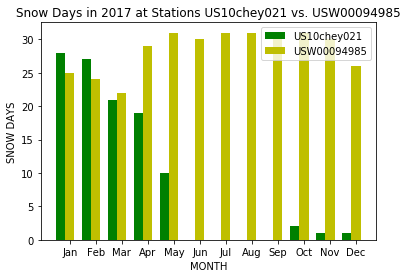

In [35]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

N=12
ind=np.arange(N)
width = 0.35
pUS10chey021 = plt.bar(ind, US10chey021_snowdays_y, width, color='g', label='US10chey021')
pUSW00094985 = plt.bar(ind+width, USW00094985_snowdays_y, width, color='y', label='USW00094985')

plt.ylabel('SNOW DAYS')
plt.xlabel('MONTH')
plt.title('Snow Days in 2017 at Stations US10chey021 vs. USW00094985')
plt.xticks(ind+width, ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.legend()

plt.show()

### Determine the number of snow days at each US weather station
To determine how many snow days there were at each of the US weather stations in 2017, run the following command to query the `snow2017` table, using the `COUNT(*)` function to get the total snow days. The table is sorted by station name and limited to only 100 stations.

In [36]:
timing("L_BeginCountSnowDays")
snowStations = spark.sql("SELECT  station, COUNT(*) AS snowdays FROM snow2017 WHERE station LIKE 'US%' GROUP BY station ORDER BY station LIMIT 100")

`L_BeginCountSnowDays` at 2018-09-25 12:53:31.399618


Now print the first 5 rows of the `snowStations` table, including the station name and number of snow days at that station:

In [37]:
snowStations.head(5)
timing("L_EndCountSnowDays","L_BeginCountSnowDays")

`L_EndCountSnowDays` at 2018-09-25 12:54:18.304491, elapsed since L_BeginCountSnowDays: 0:00:46.904873


### Save the query results into a new table

In this step, you will save the query result of the above `SELECT` query in a new table called `snowdays_2017`. The new table has two columns: STATION (name of station) and SNOWDAYS (number of snow days at the station). 

In [38]:
snowStations.registerTempTable('snowdays_2017')

Output the five stations with the highest number of snow days in 2017:

In [39]:
snowStations_top5 = spark.sql("SELECT station, snowdays FROM snowdays_2017 ORDER BY snowdays DESC LIMIT 5").collect()
for row in snowStations_top5:
    print(row)

Row(station='US10adam056', snowdays=323)
Row(station='US10dawe026', snowdays=176)
Row(station='US10cust015', snowdays=114)
Row(station='US10chey019', snowdays=112)
Row(station='US10daws001', snowdays=111)


### Identify the stations with the same number of snow days in 2017

In this section, you'll identify the stations that had the same number of snow days in 2017. First, you need to query the table `snowdays_2017` again. 

Then, by using the `map` function, you'll transform each row into a key-value pair where the key is the number of snow days and the value is the station name.

Next, you'll apply the `reduceByKey` function to each pair, and the value of those pairs that have the same key are concatenated. As a result, the RDD contains the number of snow days, and the list of all stations that have the same number of snow days.

The `for` loop prints the number of snow days, and the list of stations that have that number of snow days in 2017.

In [40]:
# Query the station's snowdays
station_snowdays = spark.sql("SELECT station, snowdays FROM snowdays_2017 ORDER BY snowdays")

# Make a RDD with snowdays as first column, used as key
snowday_station=station_snowdays.rdd.map(lambda x:  (x.snowdays,x.station))

# Collapse by key (snowdays) and make a list of stations as second column
snowday_stationsList=snowday_station.reduceByKey(lambda x, y: x + ',' + y).sortByKey().collect()
for snowday in snowday_stationsList:
    print('Snow days: {0} Stations: {1}'.format(snowday[0],snowday[1]))

Snow days: 1 Stations: US10adam001,US10adam008,US10adam010,US10blai004,US10buff019,US10burt002,US10cher008,US10cher018,US10cher024,US10cher026,US10chey005,US10chey007,US10chey010,US10chey049,US10chey053,US10chey060,US10clay009,US10colf001,US10cust003,US10cust040,US10cust041,US10dawe017
Snow days: 2 Stations: US10butl020,US10chas034,US10chey028,US10cust042
Snow days: 3 Stations: US10adam035,US10buff007
Snow days: 4 Stations: US10bann009,US10butl005,US10ceda009,US10cumi008,US10cust035
Snow days: 5 Stations: US10chas012,US10chey033,US10cumi003
Snow days: 6 Stations: US10chas016
Snow days: 7 Stations: US10clay041,US10cust005
Snow days: 8 Stations: US10boon010,US10clay008,US10colf002
Snow days: 9 Stations: US10adam036,US10cher016,US10cust032,US10dako003
Snow days: 10 Stations: US10buff004,US10chas011,US10clay029
Snow days: 11 Stations: US10butl011
Snow days: 12 Stations: US10buff039,US10cass005
Snow days: 14 Stations: US10butl008,US10ceda006,US10clay004
Snow days: 15 Stations: US10cust045
S

In [41]:
timing("M_EndSparkSQLQueries","H_BeginSparkSQL")

`M_EndSparkSQLQueries` at 2018-09-25 12:55:51.086558, elapsed since H_BeginSparkSQL: 0:04:34.305974


<a id="save"></a>
## Save results in Object Storage

In this section, you'll save the `snowStations` DataFrame, which is the query result of the `snow2017` table for 100 US weather stations in Object Storage. Each row contains the name of the weather station and the number of snow days at that station.

The data will be saved in [Apache Parquet](https://parquet.apache.org/documentation/latest/) file format, which saves data as columns.

Each project you create has a container in your object storage. The name of the container is the same as the project name, minus any blank spaces. You can get the name of the container a couple of different ways:
1. from the **Settings** page of the project
2. or using `YourCredentials['container']` variable that is generated from the **Insert Credentials** function.

In [42]:
# Save as parquet file 

# If you are running this cell multiple times, you will need to overwrite the data in the parquet file:
#     snowStations.write.mode('overwrite').parquet(bmos.url('CONTAINER', 'snowStations.parquet'))

snowStations_url = cos.url('snowStations_{0}.parquet'.format(int(datetime.now().timestamp())),bucket_name)

snowStations.write.parquet(snowStations_url)
timing("N_EndWriteToCOS","M_EndSparkSQLQueries")

`N_EndWriteToCOS` at 2018-09-25 12:56:38.834213, elapsed since M_EndSparkSQLQueries: 0:00:47.747655


After the DataFrame has been saved to Object Storage, you will see a new data source called `snowStations.parquet` in the `Data` pane of the project.   
It can further be added as a 'Data Asset' to your project.

The last cell below reads the parquet file and registers it as a table again.   
Once the parquet file is read, you can register the resulting DataFrame as TempTable, and then run SQL queries on the data as well.

In [43]:
snowDaysParquetFile = spark.read.parquet(cos.url('snowStations.parquet',bucket_name))
snowDaysParquetFile.registerTempTable("snow_from_parquet")
timing("O_ReadFromCOS","N_EndWriteToCOS")

`O_ReadFromCOS` at 2018-09-25 12:56:39.672432, elapsed since N_EndWriteToCOS: 0:00:00.838219


In [44]:
# Display structure of the DataFrame
snowDaysParquetFile.describe()

DataFrame[summary: string, station: string, snowdays: string]

In [45]:
station_snowdays = spark.sql("SELECT DISTINCT COUNT(*) AS countSnow FROM snow_from_parquet")
print('There are {0} stations'.format(station_snowdays.first().countSnow))
timing("P_EndSQLFromCOS","O_ReadFromCOS")

timing("Z_End","A_Start")

There are 100 stations
`P_EndSQLFromCOS` at 2018-09-25 12:56:42.441502, elapsed since O_ReadFromCOS: 0:00:02.769070
`Z_End` at 2018-09-25 12:56:42.441635, elapsed since A_Start: 0:07:21.221092


<a id="summary"></a>
## Summary

In this sample, you learned how to use Apache Spark, how to use PySpark, the Python API for Spark and the matplotlib plotting library. You also learned how to load data from Object Storage as an RDD, how to define Spark data schemas, and how to save intermediate results in parquet format.

<a id="resources"></a>
### Resources
- [Apache Spark 2.1.0 Programming Guide](https://spark.apache.org/docs/2.1.0/programming-guide.html)
- [Apache Spark 2.1.0 SQL and DataFrames](https://spark.apache.org/docs/2.1.0/sql-programming-guide.html)
- [PySpark 2.1.0 - Python API for Spark](https://spark.apache.org/docs/2.1.0/api/python)

### Author
Sven Hafeneger is a member of the Data Science Experience development team at IBM in Germany. He holds a M.Sc. in Bioinformatics and is passionate about data analysis, machine learning and the Python ecosystem for data science. 

<hr>
Copyright © IBM Corp. 2016, 2018. This notebook and its source code are released under the terms of the MIT License.